Supervised learning corresponds to the type of machine learning that draws inferences from datasets that have labeled training data. For example, when training a model to classify healthy and unhealthy patients, the dataset will include information about each patient and also a label as healthy or unhealthy. 

Unsupervised learning corresponds to the type of machine learning that draws inferences from datasets that have no labeld information. Unsupervised learning algorithms try to find inherent patterns in the data. For example, you want to classify photos into different types like cars, animals, buildings etc. without any labeled information available. The algorithm 'learns' about different images during the training period. Based on what it has learned, it will try to classify new images it looks at into different categories. Unsupervised learning is achieved using one of the following approaches, depending on the type of problem you are trying to solve - 
* Clustering
* Neural Networks
* Anamoly detection techniques
* Expectation-maximization algorithms
* Blind signal seperation algorithms
* Method of Moments

In this notebook, I talk and implement k-means clustering algorithm to perform clustering on Iris dataset (<http://archive.ics.uci.edu/ml/datasets/Iris?ref=datanews.io>).

<!--TEASER_END-->

In [1]:
import numpy as np
import pandas as pd
import sys
from sklearn.covariance import empirical_covariance
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set_style("white")
%matplotlib inline

## K Means Clustering Algorithm

**Goals of clustering - **
* Find groups of objects such that objects in a group will be similar (or related, using some similarity measure) to one another and different from (or unrelated) to the objects in the other group.
* Intra-cluster distances are to be minimized
* Inter-cluster distances are to be maximized

**Good clustering method - **
* High intra-class similarity
* Low inter=class similartiy
* Depends on both the similarity measure used by the method and its implementation
* It is also able to discover some or all hidden patterns in the data

**K-Means clustering algorithm - **
* Partition objects into k non-empty subsets. This is done at random, in its simplest form.
* Compute seed points as centroids of these clusters. The centroid is the center i.e. mean point of the cluster.
* Assign each object to the cluster with the nearest seed point.
* Go back to step 2, until no new assignments are possible.

**Disadvantages of K-Means - **
* The algorithm is affected by the initial random partitions into k non-empty subsets. The results depend on the initial values for mean or centroids of the cluster, many a times leading to suboptimal partitions. Standard solution is to dry a number of different starting points and check if the partitions formed are consistent across the simulations.
* Normalizing it globla covariance versus cluster variance also affects the partitions. 
* Value of k, if unknown, affect the partitions. 

![K-Means](figures/clustering_process.png)

Following class implements the k-means algorithm using Mahalanobis distance as the similarity measure. The initial assignment of cluster points can be random or pre-defined. It also takes into consideration whether to use global covariance or not when computing normalized Mahalabois distance.

For more functionality, please use scikit-learn implementation of [k-means](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).

In [2]:
class kmeans:
    def __init__(self, n_clusters, label_flag,
                 global_cov=False, random_assignment=False,
                 random_state=None, print_progress=False):
        self.n_clusters = int(n_clusters)
        self.global_cov = global_cov
        self.random_assignment = random_assignment
        self.random_state = random_state
        self.n_iter = 0  # Initialization iteration counter
        self.print_progress = print_progress
        self.means_ = []
        self.label_flag = label_flag

    def __str__(self):
        return("Untrained unsupervised k-means clustering object")

    # Compute normalized mahalanobis distance distance for given test sample
    # Compute nomralized mahalanobis distance
    # Formula: (X-mu)^(t)*sigma^(-1)*(X-mu)
    def normalized_maha_dist(self, X, mu, sigma):
        sigma_inv = np.linalg.inv(sigma)
        dist = (np.transpose(X - mu) @ sigma_inv @ (X - mu))
        # dist = np.transpose(X - mu) @ (X - mu)
        # print("\n Distances:", dist)
        return(dist)
    
    # Initial assignment of clusters
    def cluster_assignment_init(self, X):
        np.random.seed(self.random_state)
        n_rows = X.shape[0]
        # n_features = X.shape[1]
        self.label_init = np.arange(1, self.n_clusters + 1, dtype='float64')
        if self.label_flag == 0:
            labels = np.tile(self.label_init, int(n_rows / self.n_clusters))
        else:
            labels = np.loadtxt('./data/norm_labels.txt')

        if self.random_assignment:
            # Randomize initial cluster assignment
            X = np.random.permutation(X) # Randomly arranges the data
            np.random.shuffle(labels) # Shuffles the labels in place
        return (labels, self.label_init)

    def fit(self, X):
        # n_features = X.shape[1]
        labels, self.label_init = self.cluster_assignment_init(X)
        print("Start Iteration")

        while True:
            self.inertia_ = []
            dist = []
            self.n_iter += 1
            if self.print_progress:
                sys.stderr.write('\rEpoch: %d' % (self.n_iter))
                sys.stderr.flush()
            for cl in self.label_init:
                x = X[labels == cl, ]
                mu = np.mean(x, axis=0)
                self.means_.append(mu)
                if self.global_cov:
                    sigma = empirical_covariance(X) # Will remain constant
                else:
                    sigma = empirical_covariance(x) # Will change with each iteration because the cluster data points change
                dist.append(
                    np.apply_along_axis(self.normalized_maha_dist,
                                        1, X, mu, sigma))
            temp_dist = dist[0]
            for item in dist[1:]:
                temp_dist = np.vstack((temp_dist, item))
            self.inertia_ = temp_dist.T
            # self.cost_ = self.inertia_.sum().sum()
            self.labels_ = np.array(
                [(np.argmin(item) + 1) for item in self.inertia_])

            if all(labels == self.labels_):
                print("\nClusters are formed")
                break
            else:
                labels = self.labels_
        return(self.labels_)

Since we have the class labels in this case, we can analyze the cluster formation using class labels to count the number of data points in each cluster from each class.

In [3]:
# Count the number of data points in each cluster from each class
def cluster_class_count(cluster_labels, class_labels):
    for i in np.unique(cluster_labels):
        print("\nCluster" + str(i))
        cluster_points = class_labels[np.where(cluster_labels == i)]
        print("Class count", np.unique(cluster_points, return_counts=True))

# Iris Dataset

The data is arranged as one sample per line for a total of 150 lines. The first 50 lines are samples from class 1, the next 50 are from class 2 and the last 50 are from class 3. Each row contains five entries for Class, Petal Length, Sepal Length, Sepal Width and Petal Width.

In [4]:
# Read the iris dataset into a numpy array

def read_iris():
    with open('./data/Iris-Data.dat', 'r') as f:
        iris = np.array([l.rstrip().split() for l in f], dtype='float64')
    return(iris)

iris = read_iris()
X = iris[:, 1:]
y = iris[:, 0]
iris_df = pd.DataFrame(X,columns=['Petal_Length','Sepal_Length','Sepal_Wdith',"Petal_Width"])
iris_df['Species'] = y

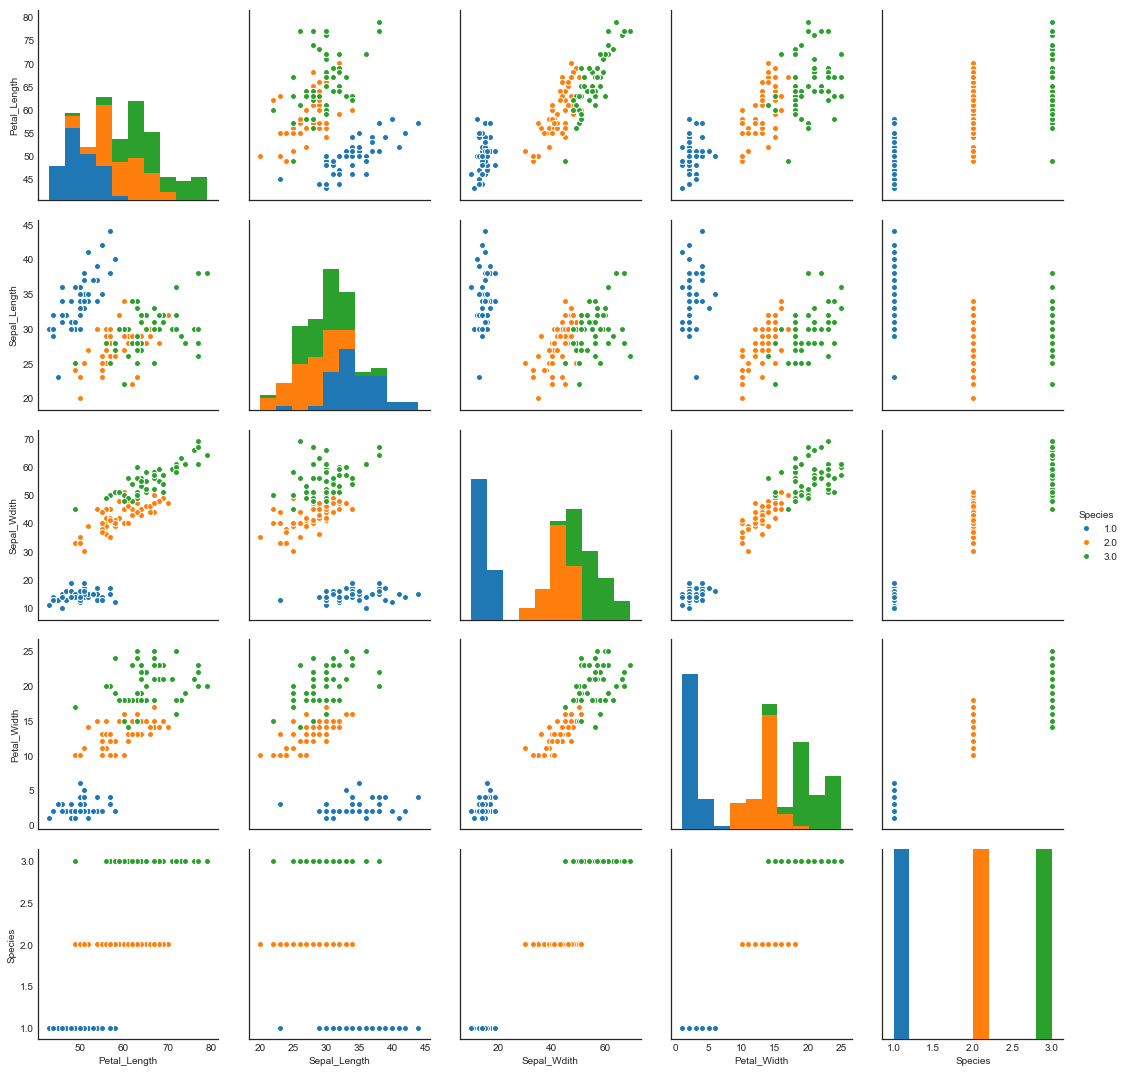

In [5]:
import seaborn as sns

sns.pairplot(iris_df,hue='Species', size=3)

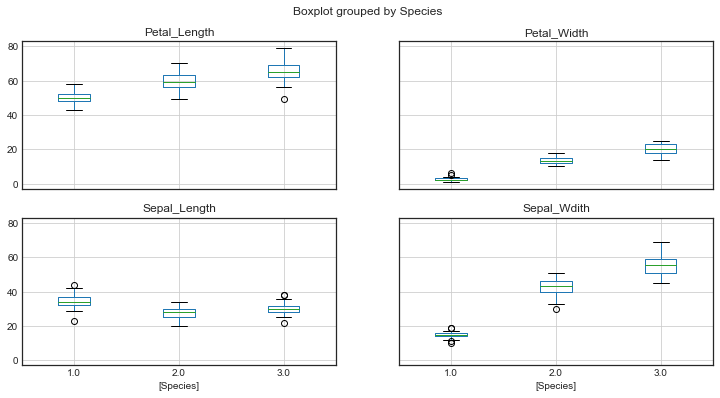

In [6]:
ax = iris_df.boxplot(by='Species',figsize=(12,6))

## Normalized by global covariance

In [7]:
clf = kmeans(n_clusters=3, global_cov=True,
          random_assignment=False,
          label_flag=0, random_state=12345, print_progress=False)
labels = clf.fit(X)
print("\nEpochs:", clf.n_iter)

Start Iteration

Clusters are formed

Epochs: 10


### Centroids of the clusters

In [8]:
print("\nCluster 1 centroids:", clf.means_[(len(clf.means_) - 3)])
print("\nCluster 2 centroids:", clf.means_[(len(clf.means_) - 2)])
print("\nCluster 3 centroids:", clf.means_[(len(clf.means_) - 1)])


Cluster 1 centroids: [ 50.06  34.28  14.62   2.46]

Cluster 2 centroids: [ 61.65853659  30.          50.36585366  19.58536585]

Cluster 3 centroids: [ 63.28813559  27.83050847  48.15254237  14.79661017]


### Total count of each cluster

In [9]:
# Total Count for each cluster
print("\nCluster 1:", (clf.labels_ == 1).sum())
print("\nCluster 2:", (clf.labels_ == 2).sum())
print("\nCluster 3:", (clf.labels_ == 3).sum())


Cluster 1: 50

Cluster 2: 41

Cluster 3: 59


### Class count in each cluster

In [10]:
cluster_class_count(clf.labels_, y)


Cluster1
Class count (array([ 1.]), array([50], dtype=int64))

Cluster2
Class count (array([ 2.,  3.]), array([10, 31], dtype=int64))

Cluster3
Class count (array([ 2.,  3.]), array([40, 19], dtype=int64))


### 3D plot
Reference - <http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_iris.html#sphx-glr-auto-examples-cluster-plot-cluster-iris-py>

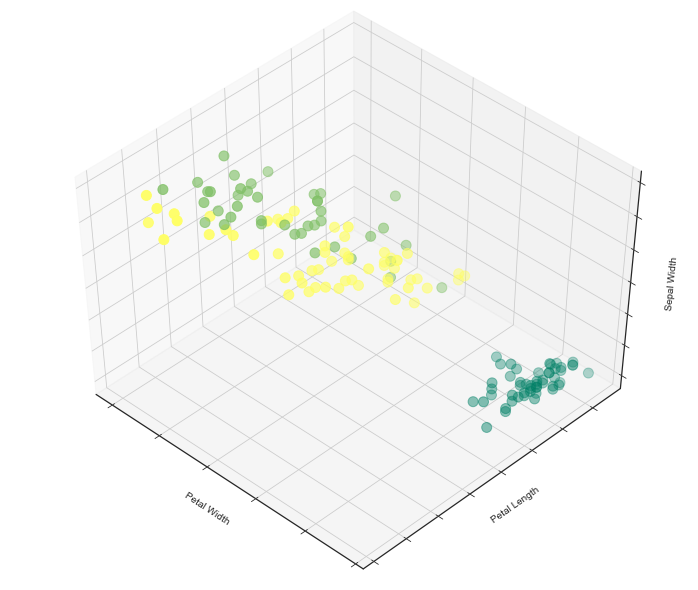

In [11]:
fig = plt.figure(figsize=(10,8))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
plt.cla()

ax.scatter(X[:, 3], X[:, 0], X[:, 2], c=labels.astype(np.float), s = 100, cmap=plt.cm.summer)
ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Petal Width')
ax.set_ylabel('Petal Length')
ax.set_zlabel('Sepal Width')

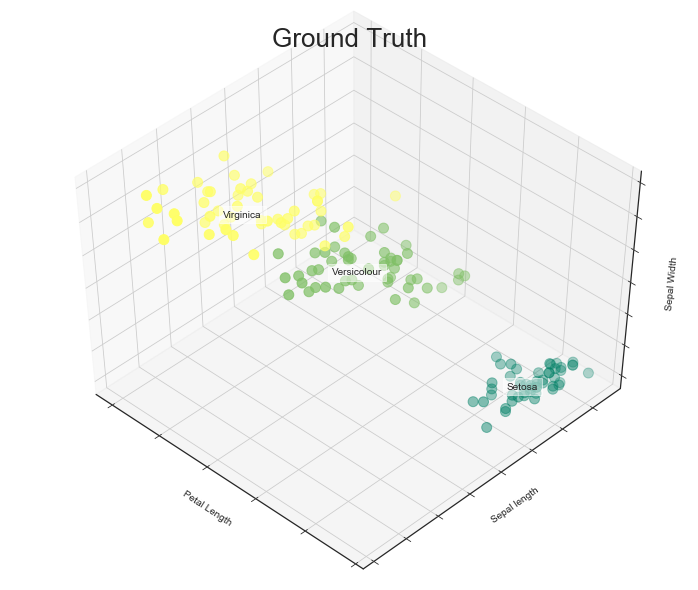

In [12]:
# Plot the ground truth
fig = plt.figure(figsize=(10,8))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

plt.cla()

for name, label in [('Setosa', 1),
                    ('Versicolour', 2),
                    ('Virginica', 3)]:
    ax.text3D(X[y == label, 3].mean(),
              X[y == label, 0].mean() + 1.5,
              X[y == label, 2].mean(), name,
              horizontalalignment='center',
              bbox=dict(alpha=.5, edgecolor='w', facecolor='w'))
# Reorder the labels to have colors matching the cluster results
ax.scatter(X[:, 3], X[:, 0], X[:, 2], c=y, s=100, cmap=plt.cm.summer)

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Petal Length')
ax.set_ylabel('Sepal length')
ax.set_zlabel('Sepal Width')
plt.title("Ground Truth", fontsize=26)
plt.show()

## Normalized by cluster variance

In [13]:
clf = kmeans(n_clusters=3, global_cov=False,
          random_assignment=False,
          label_flag=0, random_state=12345, print_progress=False)
labels = clf.fit(X)
print("\nEpochs:", clf.n_iter)

Start Iteration

Clusters are formed

Epochs: 15


### Centroids of the clusters

In [14]:
print("\nCluster 1 centroids:", clf.means_[(len(clf.means_) - 3)])
print("\nCluster 2 centroids:", clf.means_[(len(clf.means_) - 2)])
print("\nCluster 3 centroids:", clf.means_[(len(clf.means_) - 1)])


Cluster 1 centroids: [ 50.16326531  34.51020408  14.65306122   2.44897959]

Cluster 2 centroids: [ 63.8         29.97142857  53.37142857  21.08571429]

Cluster 3 centroids: [ 61.72727273  27.96969697  46.22727273  14.25757576]


### Total count of each cluster

In [15]:
# Total Count for each cluster
print("\nCluster 1:", (clf.labels_ == 1).sum())
print("\nCluster 2:", (clf.labels_ == 2).sum())
print("\nCluster 3:", (clf.labels_ == 3).sum())


Cluster 1: 49

Cluster 2: 35

Cluster 3: 66


### Class count in each cluster

In [16]:
cluster_class_count(clf.labels_, y)


Cluster1
Class count (array([ 1.]), array([49], dtype=int64))

Cluster2
Class count (array([ 2.,  3.]), array([ 1, 34], dtype=int64))

Cluster3
Class count (array([ 1.,  2.,  3.]), array([ 1, 49, 16], dtype=int64))


### 3D plot

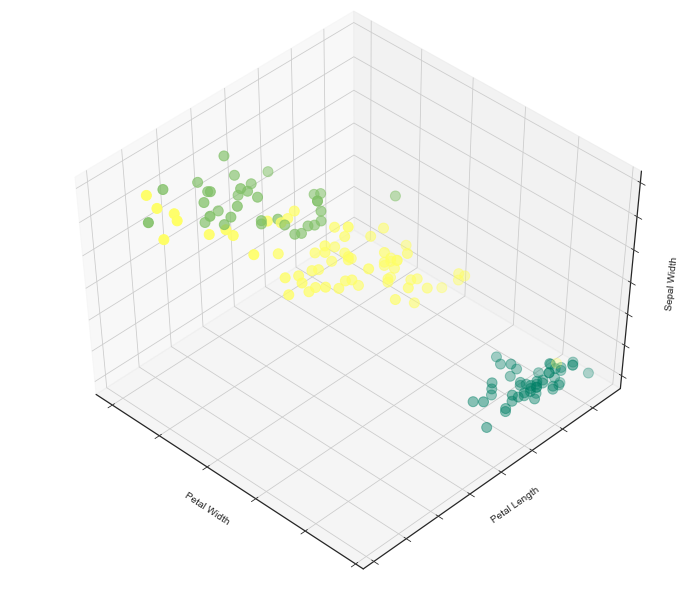

In [17]:
fig = plt.figure(figsize=(10,8))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
plt.cla()

ax.scatter(X[:, 3], X[:, 0], X[:, 2], c=labels.astype(np.float), s = 100, cmap=plt.cm.summer)
ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Petal Width')
ax.set_ylabel('Petal Length')
ax.set_zlabel('Sepal Width')